<a href="https://colab.research.google.com/github/batmanvane/AMDO/blob/main/PriceLevelLoadProductionShare2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

Get data from https://www.energy-charts.info

See API docu at https://api.energy-charts.info/#/

Bidding Zone: DE-LU

Year: 2024

Questions, improvements, corrections? Contact Robert Flassig --> https://www.linkedin.com/in/robert-flassig-661ab546/

Last Update: 17.02.2025


The data for the bidding zone is licensed as CC BY 4.0 from Bundesnetzagentur | SMARD.de


MIT License  

Copyright (c) 2025 Robert Flassig  

Permission is granted to use, copy, modify, and distribute this code for any purpose, with or without modification, provided that this notice is included.  

THE CODE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND.  


In [ ]:
import requests
import json
import datetime
import matplotlib.pyplot as plt
import numpy as np
import datetime

# Define API endpoints
price_url = "https://api.energy-charts.info/price"
production_url = "https://api.energy-charts.info/public_power"

# Parameters for the API request // here: bidding zone germany-luxemburg
params = {
    "bzn": "DE-LU",
   "start": "2024-01-01T00:00Z",
    "end": "2024-12-31T23:59Z",
}

params_production = {
    "country": "de",
    "start": "2024-01-01T00:00Z",
    "end": "2024-12-31T23:59Z",
}

headers = {
    "Content-Type": "application/json",
    "User-Agent": "Home Assistant",
    "Accept-Encoding": "identity"
}

# Fetch day-ahead auction prices
response_price = requests.get(price_url, params=params)
if response_price.status_code == 200:
    price_data = response_price.json()
else:
    #print(f"Error fetching price data: {response_price.status_code}")
    print(f"Request failed with status code {response_price.status_code}: {response_price.text}")
    price_data = {}

# Fetch production data
response_production = requests.get(production_url, params=params_production)
if response_production.status_code == 200:
    production_data = response_production.json()
else:
    print(f"Error fetching production data: {response_production.status_code}")
    production_data = {}


# Let's inspect the data first

In [ ]:
# Print out the first few entries of each dataset to understand the structure
print("Sample Price Data:", json.dumps(price_data, indent=2)[:1000])  # Limiting output size for readability
print("Sample Production Data:", json.dumps(production_data, indent=2)[:1000])


Sample Price Data: {
  "license_info": "CC BY 4.0 (creativecommons.org/licenses/by/4.0) from Bundesnetzagentur | SMARD.de",
  "unix_seconds": [
    1704067200,
    1704070800,
    1704074400,
    1704078000,
    1704081600,
    1704085200,
    1704088800,
    1704092400,
    1704096000,
    1704099600,
    1704103200,
    1704106800,
    1704110400,
    1704114000,
    1704117600,
    1704121200,
    1704124800,
    1704128400,
    1704132000,
    1704135600,
    1704139200,
    1704142800,
    1704146400,
    1704150000,
    1704153600,
    1704157200,
    1704160800,
    1704164400,
    1704168000,
    1704171600,
    1704175200,
    1704178800,
    1704182400,
    1704186000,
    1704189600,
    1704193200,
    1704196800,
    1704200400,
    1704204000,
    1704207600,
    1704211200,
    1704214800,
    1704218400,
    1704222000,
    1704225600,
    1704229200,
    1704232800,
    1704236400,
    1704240000,
    1704243600,
    1704247200,
    1704250800,
    1704254400,
    1704

# Scatterplot Load and DA Price for 2024 (Germany)

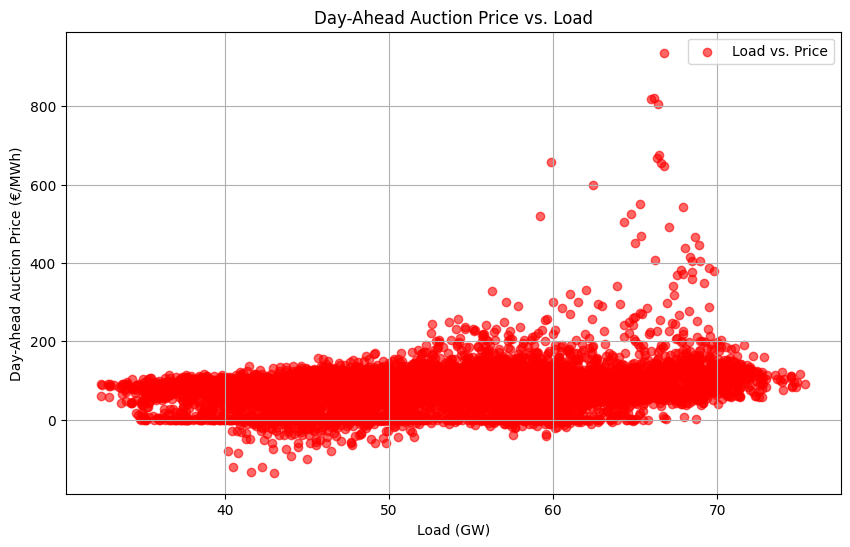

In [ ]:
# Extract timestamps and values from price data
price_timestamps = price_data.get("unix_seconds", [])
price_values = price_data.get("price", [])

# Extract timestamps from production data
production_timestamps = production_data.get("unix_seconds", [])

# Find the "Load" production type
load_data = None
for pt in production_data.get("production_types", []):
    if pt["name"].lower() == "load":  # Ensure case insensitivity
        load_data = pt["data"]
        break

# Ensure data exists before proceeding
if not price_timestamps or not price_values or not production_timestamps or load_data is None:
    print("Error: Missing required data for Load.")
else:
    # Convert price data into a dictionary
    price_dict = dict(zip(price_timestamps, price_values))

    # Convert Load production data into a dictionary
    load_dict = dict(zip(production_timestamps, load_data))

    # Find common timestamps
    common_timestamps = set(price_dict.keys()) & set(load_dict.keys())

    if not common_timestamps:
        print("No matching timestamps found between price and Load data.")
    else:
        # Extract aligned values
        aligned_load = [load_dict[ts]/1000 for ts in common_timestamps] #scale kW to GW
        aligned_prices = [price_dict[ts] for ts in common_timestamps]

        # Create scatter plot
        plt.figure(figsize=(10, 6))
        plt.scatter(aligned_load, aligned_prices, color="red", alpha=0.6, label="Load vs. Price")

        # Labels and title
        plt.xlabel("Load (GW)")
        plt.ylabel("Day-Ahead Auction Price (€/MWh)")
        plt.title("Day-Ahead Auction Price vs. Load")
        plt.legend()
        plt.grid(True)

        # Show plot
        plt.show()


# Color Renewable Share Load

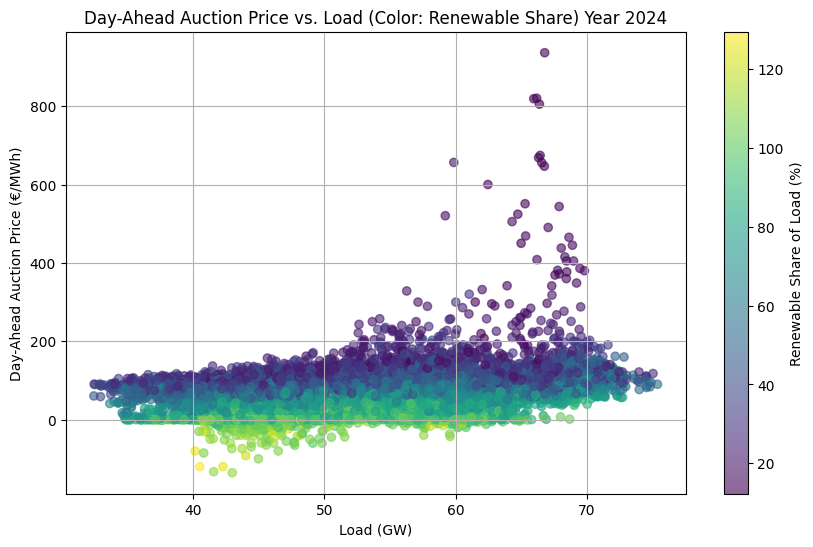

In [ ]:
# Extract timestamps and values from price data
price_timestamps = price_data.get("unix_seconds", [])
price_values = price_data.get("price", [])

# Extract timestamps from production data
production_timestamps = production_data.get("unix_seconds", [])

# Find the "Load" production type
load_data = None
renewable_share_data = None

for pt in production_data.get("production_types", []):
    if pt["name"].lower() == "load":
        load_data = pt["data"]
    elif pt["name"].lower() == "renewable share of load":
        renewable_share_data = pt["data"]

# Ensure data exists before proceeding
if not price_timestamps or not price_values or not production_timestamps or load_data is None or renewable_share_data is None:
    print("Error: Missing required data.")
else:
    # Convert price data into a dictionary
    price_dict = dict(zip(price_timestamps, price_values))

    # Convert Load production data into a dictionary
    load_dict = dict(zip(production_timestamps, [value / 1000 for value in load_data]))  # Scale kW to GW

    # Convert Renewable Share data into a dictionary
    renewable_share_dict = dict(zip(production_timestamps, renewable_share_data))

    # Find common timestamps
    common_timestamps = set(price_dict.keys()) & set(load_dict.keys()) & set(renewable_share_dict.keys())

    if not common_timestamps:
        print("No matching timestamps found between datasets.")
    else:
        # Extract aligned values
        aligned_load = [load_dict[ts] for ts in common_timestamps]
        aligned_prices = [price_dict[ts] for ts in common_timestamps]
        aligned_renewable_share = [renewable_share_dict[ts] for ts in common_timestamps]  # Renewable share as color

        # Create scatter plot with color-coded renewable share
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(aligned_load, aligned_prices, c=aligned_renewable_share, cmap="viridis", alpha=0.6)

        # Add color bar
        cbar = plt.colorbar(scatter)
        cbar.set_label("Renewable Share of Load (%)")

        # Labels and title
        plt.xlabel("Load (GW)")
        plt.ylabel("Day-Ahead Auction Price (€/MWh)")
        plt.title("Day-Ahead Auction Price vs. Load (Color: Renewable Share) Year 2024")
        plt.grid(True)

        # Show plot
        plt.show()


# Color Renewable Share Load + Saison

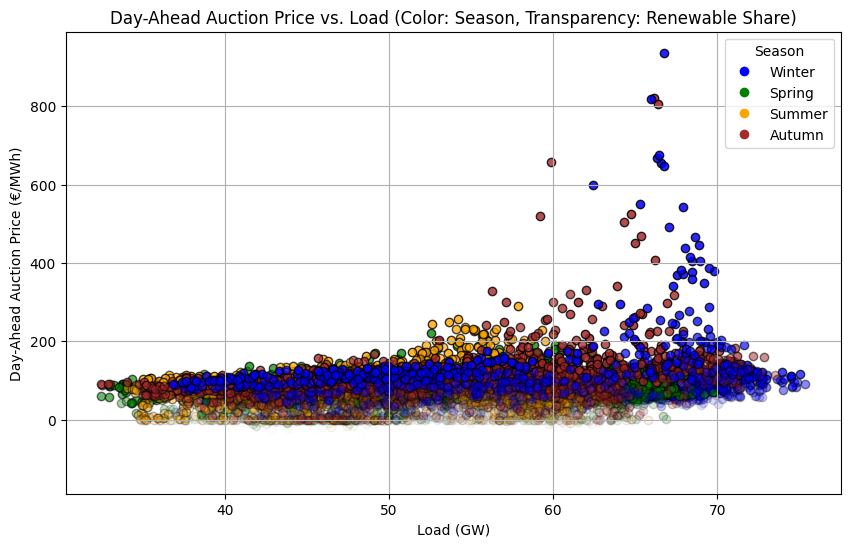

In [ ]:
# Extract timestamps and values from price data
price_timestamps = price_data.get("unix_seconds", [])
price_values = price_data.get("price", [])

# Extract timestamps from production data
production_timestamps = production_data.get("unix_seconds", [])

# Find the "Load" and "Renewable Share of Load" production types
load_data = None
renewable_share_data = None

for pt in production_data.get("production_types", []):
    if pt["name"].lower() == "load":
        load_data = pt["data"]
    elif pt["name"].lower() == "renewable share of load":
        renewable_share_data = pt["data"]

# Ensure data exists before proceeding
if not price_timestamps or not price_values or not production_timestamps or load_data is None or renewable_share_data is None:
    print("Error: Missing required data.")
else:
    # Convert price data into a dictionary
    price_dict = dict(zip(price_timestamps, price_values))

    # Convert Load production data into a dictionary, scaling from kW to GW
    load_dict = dict(zip(production_timestamps, [value / 1000 for value in load_data]))

    # Convert Renewable Share data into a dictionary
    renewable_share_dict = dict(zip(production_timestamps, renewable_share_data))

    # Find common timestamps
    common_timestamps = sorted(set(price_dict.keys()) & set(load_dict.keys()) & set(renewable_share_dict.keys()))

    if not common_timestamps:
        print("No matching timestamps found between datasets.")
    else:
        # Extract aligned values
        aligned_load = [load_dict[ts] for ts in common_timestamps]
        aligned_prices = [price_dict[ts] for ts in common_timestamps]
        aligned_renewable_share = [min(renewable_share_dict[ts] / 100, 1) for ts in common_timestamps]  # Clamp value to 0-1 range for alpha

        # Determine seasons based on timestamps
        seasons = []
        for ts in common_timestamps:
            month = datetime.datetime.utcfromtimestamp(ts).month
            if month in [12, 1, 2]:
                seasons.append("Winter")
            elif month in [3, 4, 5]:
                seasons.append("Spring")
            elif month in [6, 7, 8]:
                seasons.append("Summer")
            else:
                seasons.append("Autumn")

        # Define colors for each season
        season_colors = {"Winter": "blue", "Spring": "green", "Summer": "orange", "Autumn": "brown"}
        colors = [season_colors[season] for season in seasons]

        # Create scatter plot with seasonal colors and opacity based on renewable share
        plt.figure(figsize=(10, 6))
        for i in range(len(aligned_load)):
            plt.scatter(aligned_load[i], aligned_prices[i], color=colors[i], alpha=(1-aligned_renewable_share[i]), edgecolors="black")

        # Create custom legend
        handles = [plt.Line2D([0], [0], marker='o', color='w', label=season, markersize=8, markerfacecolor=color)
                   for season, color in season_colors.items()]
        plt.legend(handles=handles, title="Season")

        # Labels and title
        plt.xlabel("Load (GW)")
        plt.ylabel("Day-Ahead Auction Price (€/MWh)")
        plt.title("Day-Ahead Auction Price vs. Load (Color: Season, Transparency: Renewable Share)")
        plt.grid(True)

        # Show plot
        plt.show()


# Getting To The Final Plots 1/3

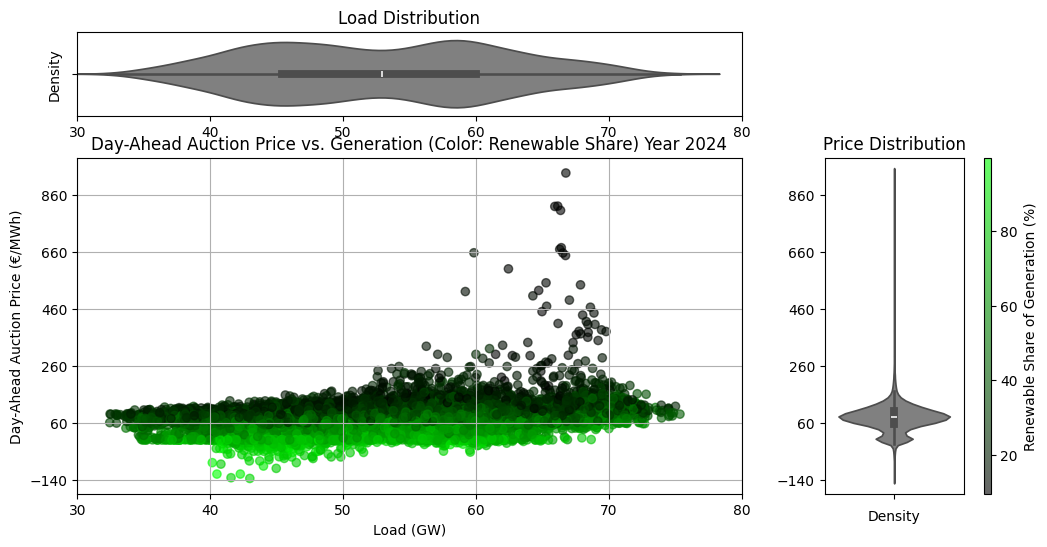

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors  # Import for custom colormap

# Ensure data exists before proceeding
if not price_timestamps or not price_values or not production_timestamps or load_data is None or renewable_share_data is None:
    print("Error: Missing required data.")
else:
    # Convert price data into a dictionary
    price_dict = dict(zip(price_timestamps, price_values))

    # Convert Load production data into a dictionary
    load_dict = dict(zip(production_timestamps, [value / 1000 for value in load_data]))  # Scale kW to GW

    # Convert Renewable Share data into a dictionary and scale to max 100%
    renewable_share_array = np.array(renewable_share_data)
    max_renewable_share = renewable_share_array.max()  # Get max value

    if max_renewable_share > 0:  # Avoid division by zero
        renewable_share_scaled = (renewable_share_array / max_renewable_share) * 100
    else:
        renewable_share_scaled = renewable_share_array  # If max is zero, keep as is

    renewable_share_dict = dict(zip(production_timestamps, renewable_share_scaled))

    # Find common timestamps
    common_timestamps = set(price_dict.keys()) & set(load_dict.keys()) & set(renewable_share_dict.keys())

    if not common_timestamps:
        print("No matching timestamps found between datasets.")
    else:
        # Extract aligned values
        aligned_load = [load_dict[ts] for ts in common_timestamps]
        aligned_prices = [price_dict[ts] for ts in common_timestamps]
        aligned_renewable_share = [renewable_share_dict[ts] for ts in common_timestamps]  # Renewable share as color

        # Convert data into a DataFrame for seaborn
        data = pd.DataFrame({
            "Load (GW)": aligned_load,
            "Price (€/MWh)": aligned_prices,
            "Renewable Share (%)": aligned_renewable_share  # Now scaled to 0-100%
        })

        # Define a custom colormap from black to green
        cmap_black_green = mcolors.LinearSegmentedColormap.from_list("black_to_green", [(0, 0, 0), (0, 1, 0)])

        # Create the figure and define layout
        fig = plt.figure(figsize=(15, 6))
        grid = plt.GridSpec(4, 5, hspace=0.5, wspace=0.5)  # Adjusted to 4 rows and 5 columns

        # Scatter plot
        ax_scatter = fig.add_subplot(grid[1:4, 0:3])
        scatter = ax_scatter.scatter(
            data["Load (GW)"], data["Price (€/MWh)"],
            c=data["Renewable Share (%)"], cmap=cmap_black_green, alpha=0.6
        )

        # Labels and title for scatter plot
        ax_scatter.set_xlabel("Load (GW)")
        # ax_scatter.set_xticks(np.linspace(x_min, x_max, num=10))
        ax_scatter.set_ylabel("Day-Ahead Auction Price (€/MWh)")
        # ax_scatter.set_yticks(np.linspace(y_min, y_max, num=10))
        ax_scatter.set_title("Day-Ahead Auction Price vs. Generation (Color: Renewable Share) Year 2024")
        ax_scatter.grid(True)

        # Calculate x_min, x_max, y_min, y_max
        x_min = data["Load (GW)"].min()
        x_max = data["Load (GW)"].max()
        y_min = data["Price (€/MWh)"].min()
        y_max = data["Price (€/MWh)"].max()

        # Round limits to nearest 10, 200
        x_min_rounded = np.floor(x_min / 10) * 10
        x_max_rounded = np.ceil(x_max / 10) * 10
        y_min_rounded = np.floor(y_min / 10) * 10
        y_max_rounded = np.ceil(y_max / 10) * 10

        # Set ticks at intervals of 10 (adjust as needed)
        ax_scatter.set_xticks(np.arange(x_min_rounded, x_max_rounded + 1, 10))
        ax_scatter.set_yticks(np.arange(y_min_rounded, y_max_rounded + 1, 200))

        # Get limits for alignment
        x_min, x_max = ax_scatter.get_xlim()
        y_min, y_max = ax_scatter.get_ylim()

        # Violin plot for Load (Top)
        ax_violin_x = fig.add_subplot(grid[0, 0:3], sharex=ax_scatter)
        sns.violinplot(x=data["Load (GW)"], color="grey", ax=ax_violin_x)
       # ax_violin_x.set_xticks([])
        ax_violin_x.set_xlabel("")
        ax_violin_x.set_ylabel("Density")
        ax_violin_x.set_title("Load Distribution")
        ax_violin_x.set_xlim(x_min, x_max)

        from mpl_toolkits.axes_grid1 import make_axes_locatable

        # Violin plot for Prices (Right)
        ax_violin_y = fig.add_subplot(grid[1:4, 3], sharey=ax_scatter)
        sns.violinplot(y=data["Price (€/MWh)"], color="grey", ax=ax_violin_y)
        ax_violin_y.set_ylabel("")
        ax_violin_y.set_xlabel("Density")
        ax_violin_y.set_title("Price Distribution")
        ax_violin_y.set_ylim(y_min, y_max)

        # ---- Place Colorbar Next to Violin Plot ----
        divider = make_axes_locatable(ax_violin_y)
        cbar_ax = divider.append_axes("right", size="5%", pad=0.2)  # Adjust size and spacing
        cbar = plt.colorbar(scatter, cax=cbar_ax)
        cbar.set_label("Renewable Share of Generation (%)")

        # Export as PDF
        plt.savefig('day_ahead_auction_price_vs_load_renewable_share.pdf', bbox_inches='tight')

        # Show the plot
        plt.show()


# Getting To The Final Plots 2/3

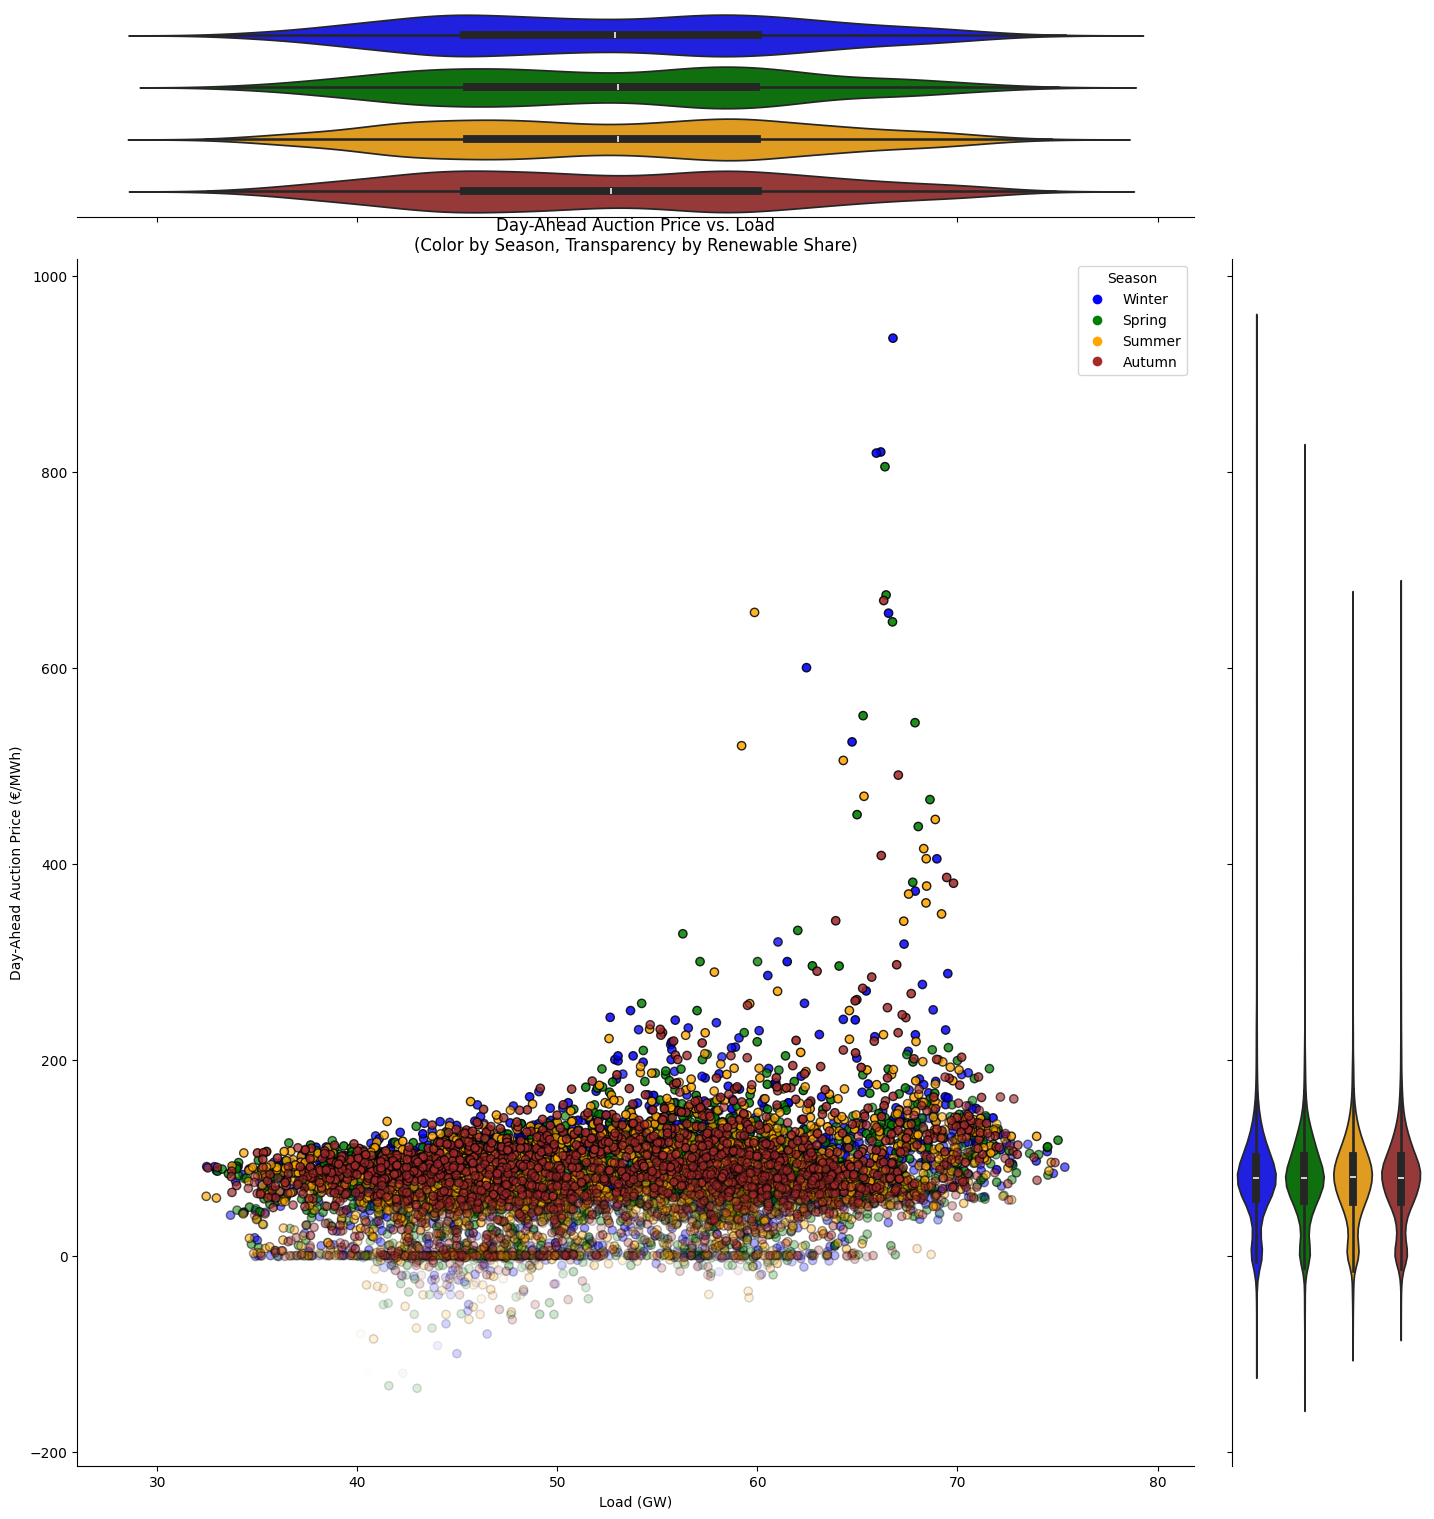

In [ ]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# -----------------------------------
# 1. Prepare your aligned DataFrame
# -----------------------------------
# (Assuming you’ve already computed these lists)
#   - common_timestamps
#   - aligned_load
#   - aligned_prices
#   - aligned_renewable_share (clamped 0..1)
#   - seasons (["Winter", "Spring", "Summer", "Autumn"])
#   - season_colors = {"Winter": "blue", "Spring": "green", "Summer": "orange", "Autumn": "brown"}

aligned_renewable_share = [
    max(min(renewable_share_dict[ts] / 100, 1), 0)  # Ensures values are always 0 <= x <= 1
    for ts in common_timestamps
]


df = pd.DataFrame({
    "Load (GW)": aligned_load,
    "Price (€/MWh)": aligned_prices,
    "Renewable Share": aligned_renewable_share,  # for alpha
    "Season": seasons
})

# -----------------------------------
# 2. Create the JointGrid
# -----------------------------------
g = sns.JointGrid(data=df, x="Load (GW)", y="Price (€/MWh)", height=8)

# -------------------------------------------------
# 3. Plot the scatter points in the main joint Axes
# -------------------------------------------------
# We'll manually loop over the seasons so that
# we can color each season differently and apply
# alpha based on Renewable Share.
for season, color in season_colors.items():
    # Filter data for the current season
    subset = df[df["Season"] == season]
    # Use (1 - renewable_share) for alpha
    g.ax_joint.scatter(
        subset["Load (GW)"],
        subset["Price (€/MWh)"],
        color=color,
        alpha=(1 - subset["Renewable Share"]),
        edgecolors="black",
        label=season
    )
# -------------------------------------------------
# 4. Marginal distributions with Violin Plots
# -------------------------------------------------
# Top (X) Marginal: Distribution of Load
# Top (X) Marginal: Distribution of Load (Horizontally aligned violins)
sns.violinplot(
    data=df,
    y="Season",       # Seasons on Y-axis
    x="Load (GW)",    # Load values on X-axis
    hue="Season",     # Use season colors
    palette=season_colors,
    dodge=False,      # Ensure each season gets a distinct violin
    orient="h",       # Horizontal orientation
    ax=g.ax_marg_x
)
g.ax_marg_x.grid(False)

# Right (Y) Marginal: Distribution of Prices
# Price (Y-Axis Marginal)
sns.violinplot(
    data=df,
    x="Season",
    y="Price (€/MWh)",
    hue="Season",
    palette=season_colors,
    dodge=False,
    orient="v",
    ax=g.ax_marg_y
)
g.ax_marg_y.grid(False)

# -------------------------------------------------
# 5. Final labeling and a custom legend
# -------------------------------------------------
g.ax_joint.set_title("Day-Ahead Auction Price vs. Load\n(Color by Season, Transparency by Renewable Share)")

# Increase space between top violin plots and title
g.fig.subplots_adjust(top=2.5)  # Adjust top margin, default is ~0.95
g.fig.set_size_inches(15, 6)  # Adjust width (15) and height (6)

g.set_axis_labels("Load (GW)", "Day-Ahead Auction Price (€/MWh)")

# Build a custom legend showing each Season color
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=season,
               markerfacecolor=color, markersize=8)
    for season, color in season_colors.items()
]
g.ax_joint.legend(handles=handles, title="Season", loc="best")
# Export as PDF
plt.savefig('day_ahead_auction_season.pdf', bbox_inches='tight')
# Show the plot
plt.show()




# Getting To The Final Plots 3/3

<ipython-input-15-dccfc3c7d7e4>:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_violin_x.legend().remove()  # Remove redundant legend
<ipython-input-15-dccfc3c7d7e4>:106: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_violin_y.set_xticklabels(ax_violin_y.get_xticklabels(), rotation=45, ha="right")
<ipython-input-15-dccfc3c7d7e4>:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_violin_y.legend().remove()


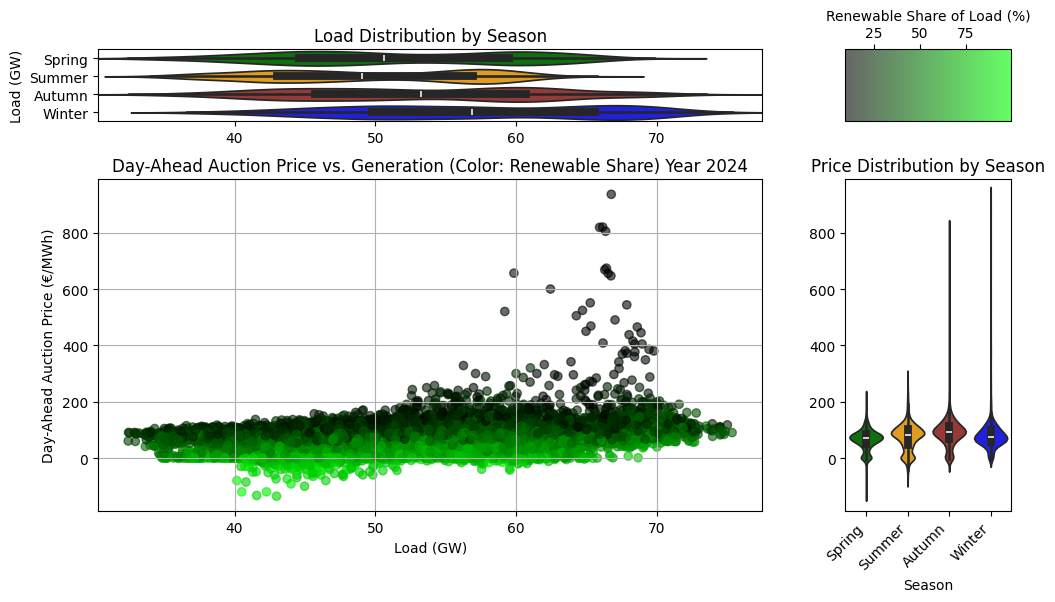

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Ensure data exists before proceeding
if not price_timestamps or not price_values or not production_timestamps or load_data is None or renewable_share_data is None:
    print("Error: Missing required data.")
else:
    # Convert price data into a dictionary
    price_dict = dict(zip(price_timestamps, price_values))

    # Convert Load production data into a dictionary
    load_dict = dict(zip(production_timestamps, [value / 1000 for value in load_data]))  # Scale kW to GW

    # Convert Renewable Share data into a dictionary and scale to max 100%
    renewable_share_array = np.array(renewable_share_data)
    max_renewable_share = renewable_share_array.max()

    if max_renewable_share > 0:
        renewable_share_scaled = (renewable_share_array / max_renewable_share) * 100
    else:
        renewable_share_scaled = renewable_share_array

    renewable_share_dict = dict(zip(production_timestamps, renewable_share_scaled))

    # Find common timestamps
    common_timestamps = set(price_dict.keys()) & set(load_dict.keys()) & set(renewable_share_dict.keys())

    if not common_timestamps:
        print("No matching timestamps found between datasets.")
    else:
        # Extract aligned values
        aligned_load = [load_dict[ts] for ts in common_timestamps]
        aligned_prices = [price_dict[ts] for ts in common_timestamps]
        aligned_renewable_share = [renewable_share_dict[ts] for ts in common_timestamps]

        # Assign seasons based on timestamps
        seasons = []
        for ts in common_timestamps:
            month = datetime.datetime.utcfromtimestamp(ts).month
            if month in [12, 1, 2]:
                seasons.append("Winter")
            elif month in [3, 4, 5]:
                seasons.append("Spring")
            elif month in [6, 7, 8]:
                seasons.append("Summer")
            else:
                seasons.append("Autumn")

        # Create DataFrame
        data = pd.DataFrame({
            "Load (GW)": aligned_load,
            "Price (€/MWh)": aligned_prices,
            "Renewable Share (%)": aligned_renewable_share,
            "Season": seasons
        })

        # Define a custom colormap for Renewable Share (black → green)
        cmap_black_green = mcolors.LinearSegmentedColormap.from_list("black_to_green", [(0, 0, 0), (0, 1, 0)])

        # Define season colors
        season_colors = {"Winter": "blue", "Spring": "green", "Summer": "orange", "Autumn": "brown"}

        # Create figure layout
        fig = plt.figure(figsize=(15, 6))
        grid = plt.GridSpec(4, 5, hspace=0.8, wspace=0.5)

        # Scatter plot
        ax_scatter = fig.add_subplot(grid[1:4, 0:3])
        scatter = ax_scatter.scatter(
            data["Load (GW)"], data["Price (€/MWh)"],
            c=data["Renewable Share (%)"], cmap=cmap_black_green, alpha=0.6
        )

        # Labels and title for scatter plot
        ax_scatter.set_xlabel("Load (GW)")
        ax_scatter.set_ylabel("Day-Ahead Auction Price (€/MWh)")
        ax_scatter.set_title("Day-Ahead Auction Price vs. Generation (Color: Renewable Share) Year 2024")
        ax_scatter.grid(True)

        # Get limits for alignment
        x_min, x_max = ax_scatter.get_xlim()
        y_min, y_max = ax_scatter.get_ylim()

        # ----- Violin plot for Load (Top) -----
        ax_violin_x = fig.add_subplot(grid[0, 0:3], sharex=ax_scatter)
        sns.violinplot(
            data=data, y="Season", x="Load (GW)", hue="Season",
            palette=season_colors, dodge=False, ax=ax_violin_x, orient="h"
        )
        ax_violin_x.set_xlabel("")
        ax_violin_x.set_ylabel("Load (GW)")
        ax_violin_x.set_title("Load Distribution by Season")
        ax_violin_x.set_xlim(x_min, x_max)
        ax_violin_x.legend().remove()  # Remove redundant legend

        # ----- Violin plot for Prices (Right) -----
        ax_violin_y = fig.add_subplot(grid[1:4, 3], sharey=ax_scatter)
        sns.violinplot(
            data=data, x="Season", y="Price (€/MWh)", hue="Season",
            palette=season_colors, dodge=False, orient="v", ax=ax_violin_y
        )
        ax_violin_y.set_xticklabels(ax_violin_y.get_xticklabels(), rotation=45, ha="right")
        ax_violin_y.set_ylabel("")
        ax_violin_y.set_xlabel("Season")
        ax_violin_y.set_title("Price Distribution by Season")
        ax_violin_y.set_ylim(y_min, y_max)
        ax_violin_y.legend().remove()

        # ---- Place Colorbar at (0,3) and Make It Horizontal ----
        cbar_ax = fig.add_subplot(grid[0, 3])  # Move colorbar to row 0, column 3
        cbar = plt.colorbar(scatter, cax=cbar_ax, orientation="horizontal")  # Set to horizontal
        cbar.set_label("Renewable Share of Load (%)")

        # Adjust tick positions and alignment
        cbar.ax.xaxis.set_ticks_position("top")  # Move ticks to top
        cbar.ax.xaxis.set_label_position("top")

        # Export as PDF
        plt.savefig('day_ahead_auction_price_vs_load_renewable_share_saison.pdf', bbox_inches='tight')

        # Show the plot
        plt.show()
